# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pywt

from skimage import io
from skimage.util import random_noise
from skimage.color import rgb2gray

# Functions

## WT 1D

In [2]:
# x = 1D Signal [x_0, x_1, ..., x_n]
# w = Filter  [c, d]
def dwt(x, w, j):
  c = w[0]  # Low-pass filter  
  d = w[1]  # High-pass filter

  # Convolution
  y0 = []
  y1 = []
  # for n in range(len(x) + len(c) - 1):
  for n in range(len(x) + len(c) - 2):
    sum0 = 0
    sum1 = 0
    for k in range(len(c)):
      if n - k < 0 or n >= len(x):
        aux = 0
      else:
        aux = x[n - k]
      
      sum0 += aux * c[k]
      sum1 += aux * d[k]

    y0.append(sum0)
    y1.append(sum1)

  # Downsampling
  v0 = []
  v1 = []
  for i in enumerate(zip(y0, y1)):
    if i[0] % 2 != 0:
      v0.append(i[1][0])
      v1.append(i[1][1])

  if j > 1:
    return [dwt(v0, w, j - 1), v1]    # Decompose the signal recursively
  return [v0, v1]


In [3]:
# x = Decomposed signal [L, H]
# w = Filters [f, g]
def idwt(x, w, j):
  if j > 1:
    x = [idwt(x[0], w, j - 1), x[1]]  # Recursively restore the signal

  f = w[0]  # Low-pass filter  
  g = w[1]  # High-pass filter

  # Upsampling
  u = []
  for i in enumerate(x):
    u.append([])
    for k in i[1]:
      u[i[0]].append(k)
      u[i[0]].append(0)

  # Convolution
  w0 = []
  w1 = []
  # for n in range(len(u[0]) + len(f) - 1):
  for n in range(len(u[0]) + len(f) - 2):
    sum0 = 0
    sum1 = 0
    for k, (ff, gg) in enumerate(zip(f, g)):
      if n - k < 0 or n >= len(u[0]) or n >= len(u[1]):
        aux0 = 0
        aux1 = 0
      else:
        aux0 = u[0][n - k]
        aux1 = u[1][n - k]
      
      sum0 += aux0 * ff
      sum1 += aux1 * gg

    w0.append(sum0)
    w1.append(sum1)

  # w0 + w1 results in the concatenation of the lists
  return [i + k for i, k in zip(w0, w1)]

### Test

In [4]:
# Testing
w = pywt.Wavelet('haar')
fb  = w.filter_bank
x = [-2, 1, 3, 2, -3, 4]
j = 1

decW = fb[:2]  # Decomposition  (c and d)
recW = fb[2:]  # Reconstruction (f and g)

d = dwt(x, decW, j)
for i in enumerate(d):
  print(f'Dec {i[0]}: {i[1]}')

id = idwt(d, recW, j)
print(f'\nRec: {id}')

print(f'\nDif = {[round(i - j, 16) for i, j in zip(x, id)]}')

Dec 0: [-0.7071067811865476, 3.5355339059327378, 0.7071067811865475]
Dec 1: [-2.121320343559643, 0.7071067811865477, -4.949747468305834]

Rec: [-2.0000000000000004, 1.0, 3.0000000000000004, 2.0000000000000004, -3.000000000000001, 4.000000000000001]

Dif = [4e-16, 0.0, -4e-16, -4e-16, 9e-16, -9e-16]


## WT 2D

In [5]:
# x = 2D Signal | Image (numpy.ndarray)
# w = Filters [c, d]
def dwt2d(x, w, j):
  l = []
  h = []
  # DWT for each row
  for row in x:
    aux = dwt(row, w, 1)
    l.append(aux[0])
    h.append(aux[1])

  l = np.array(l)
  h = np.array(h)

  ll = np.array([[] for i in range(len(l[0]))])
  lh = np.array([[] for i in range(len(l[0]))])

  hl = np.array([[] for i in range(len(h[0]))])
  hh = np.array([[] for i in range(len(h[0]))])

  # DWT for each column
  for i in range(len(l[0])):
    aux = dwt(l[:, i], w, 1)
    ll = np.column_stack((ll, aux[0]))
    lh = np.column_stack((lh, aux[1]))

  for i in range(len(h[0])):
    aux = dwt(h[:, i], w, 1)
    hl = np.column_stack((hl, aux[0]))
    hh = np.column_stack((hh, aux[1]))

  if j > 1:
    # Decompose the signal recursively
    return [dwt2d(ll, w, j - 1), [lh, hl, hh]]
  return [ll, [lh, hl, hh]]

In [6]:
# x = [LL, [LH, HL, HH]]
# w = Filters [f, g]
def idwt2d(x, w, j):
  if j > 1:
    x = [idwt2d(x[0], w, j - 1), x[1]]  # Recursively restore the signal

  ll = x[0]
  lh = x[1][0]
  hl = x[1][1]
  hh = x[1][2]

  l = []
  h = []
  # IDWT for each row para cada row of L_ and H_ pairs
  for a, b in zip(ll, lh):
    l.append(idwt([a, b], w, 1))

  for a, b in zip(hl, hh):
    h.append(idwt([a, b], w, 1))

  l = np.array(l)
  h = np.array(h)

  # rec = np.array with the same resolution as the original image 
  # Adds a line for each column of L 
  rec = np.array([[] for i in range(len(l[0]))])

  # IFWT for each column of L and H
  for a, b in zip(range(len(l[0])), range(len(h[0]))):
    aux = [l[:,a], h[:,b]]
    rec = np.column_stack((rec, idwt(aux, w, 1)))

  return rec



# Haar wavelets

\begin{align}
\ c = \frac{1}{\sqrt 2}[1, 1]
\
\
\
\
\ d = \frac{1}{\sqrt 2}[1, -1]
\end{align}
 
\begin{align}
\ f = \frac{1}{\sqrt 2}[1, 1]
\
\
\
\
\ g = \frac{1}{\sqrt 2}[-1, 1]
\end{align}

The PyWavelets library "inverts" the *d* and *g* filters in relation to the slides, but still gives correct results, as they are inverses. For the library:

\begin{align}
\ d =~...[1, -1]
\
\
\
\
\ g =~...[-1, 1]
\end{align}

In [7]:
w = pywt.Wavelet('haar')
fb  = w.filter_bank
# [dec_lo, dec_hi, rec_lo, rec_hi]
# fb = ([0.7071067811865476, 0.7071067811865476], [-0.7071067811865476, 0.7071067811865476], dec_lo (c), dec_hi (d)
#       [0.7071067811865476, 0.7071067811865476], [0.7071067811865476, -0.7071067811865476]) rec_lo (f), rec_hi (g)

# Wavelets
decW = fb[:2]  # Decomposition  (c and d)
recW = fb[2:]  # Reconstruction (f and g)

# 1)

In [8]:
j = 2

# Signal
x = [1, 2, -1, 3, 6, -2, -1, 3]

## PyWavelets results

In [9]:
pywtDec = pywt.wavedec(x, w, level = j)
print(f'Dec: {pywtDec}')

pywtRec = pywt.waverec(pywtDec, w)
print(f'Rec: {pywtRec}')

Dec: [array([2.5, 3. ]), array([0.5, 1. ]), array([-0.70710678, -2.82842712,  5.65685425, -2.82842712])]
Rec: [ 1.  2. -1.  3.  6. -2. -1.  3.]


## My results

Dec 0: [[2.5000000000000004, 3.000000000000001], [0.5, 1.0000000000000002]]
Dec 1: [-0.7071067811865476, -2.8284271247461903, 5.656854249492381, -2.8284271247461903]

Rec: [1.0000000000000004, 2.000000000000001, -1.0, 3.000000000000001, 6.000000000000002, -2.0000000000000004, -1.0, 3.000000000000001]

Dif = [-4e-16, -9e-16, 0.0, -9e-16, -1.8e-15, 4e-16, 0.0, -9e-16]



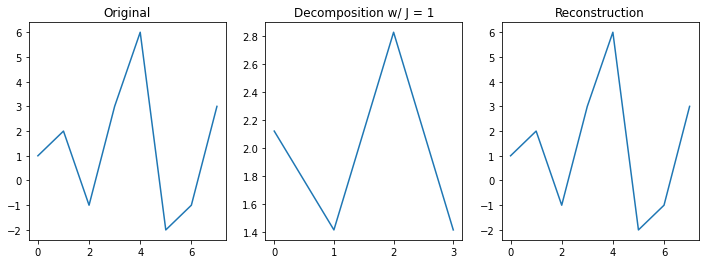

In [10]:
# x = Signal | decW = Wavelet |
dec = dwt(x, decW, j)
for i in enumerate(dec):
  print(f'Dec {i[0]}: {i[1]}')

rec = idwt(dec, recW, j)
print(f'\nRec: {rec}')

print(f'\nDif = {[round(i - j, 16) for i, j in zip(x, rec)]}\n')

# Plot signals
fig, ax = plt.subplots(1, 3, figsize=[12, 4])

ax[0].set_title('Original')
ax[0].plot(x)

ax[1].set_title('Decomposition w/ J = 1')
ax[1].plot(dwt(x, decW, 1)[0])

ax[2].set_title('Reconstruction')
ax[2].plot(rec)
plt.show()

# 2)

barbara.jpg

<img src=https://i.imgur.com/YTIOmF3.jpg width="250">


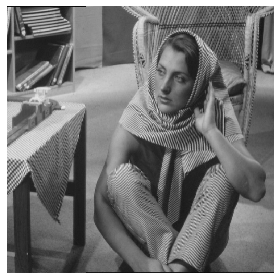

In [11]:
img = rgb2gray(io.imread('../img/barbara.jpg'))

plt.axis('off')
io.imshow(img)

j = 2

## PyWavelets results

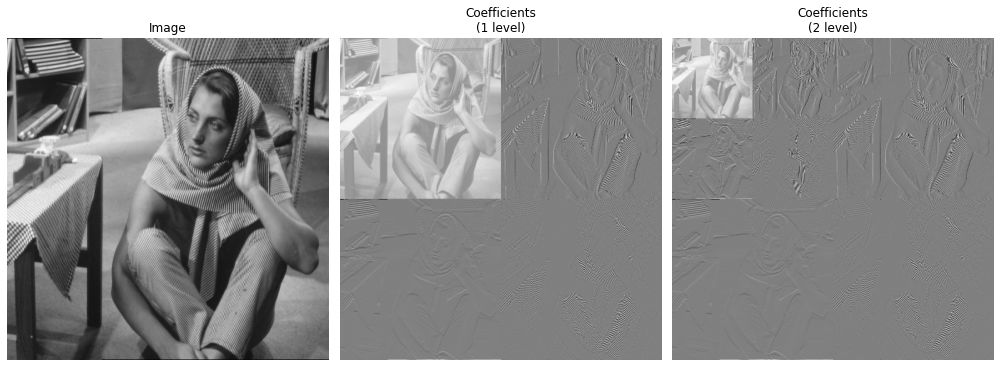

In [12]:
# Source: https://pywavelets.readthedocs.io/en/latest/ref/2d-decompositions-overview.html

shape = img.shape

max_lev = j       # how many levels of decomposition to draw
label_levels = j  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(1, j + 1, figsize=[14, 8])
for level in range(0, max_lev + 1):
  if level == 0:
      # show the original image before decomposition
      axes[0].imshow(img, cmap=plt.cm.gray)
      axes[0].set_title('Image')
      axes[0].set_axis_off()
      continue

  # compute the 2D DWT
  c = pywt.wavedec2(img, w, mode='periodization', level=level)
  # normalize each coefficient array independently for better visibility
  c[0] /= np.abs(c[0]).max()
  for detail_level in range(level):
      c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
  # show the normalized coefficients
  arr, slices = pywt.coeffs_to_array(c)
  axes[level].imshow(arr, cmap=plt.cm.gray)
  axes[level].set_title('Coefficients\n({} level)'.format(level))
  axes[level].set_axis_off()

plt.tight_layout()
plt.show()

In [13]:
# rec = pywt.waverec2(coeffs, w)

## My results

In [14]:
dec = dwt2d(img, decW, j)
rec = idwt2d(dec, recW, j)

<Figure size 432x288 with 0 Axes>

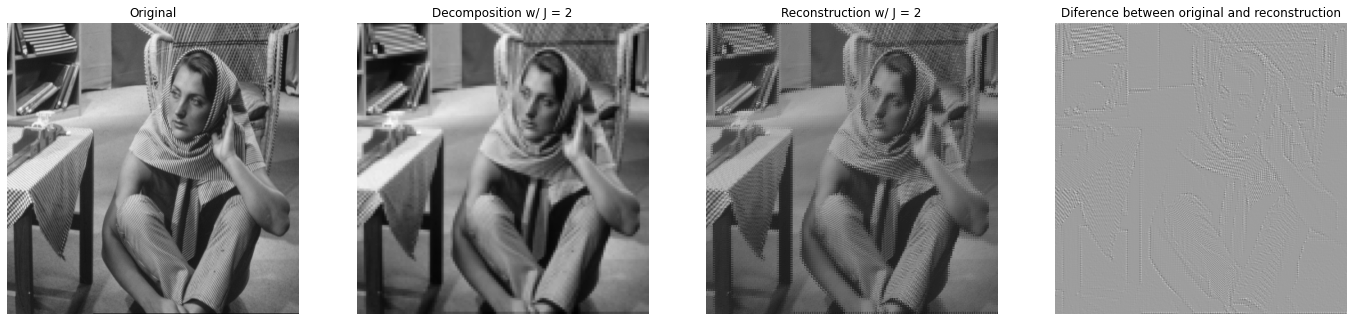

In [15]:
plt.set_cmap('gray')
fig, ax = plt.subplots(1, 4, figsize=[24, 16])

ax[0].set_title('Original')
ax[0].axis('off')
ax[0].imshow(img)

ax[1].set_title('Decomposition w/ J = 2')
ax[1].axis('off')
ax[1].imshow(dwt2d(img, decW, 2)[0][0])

ax[2].set_title(f'Reconstruction w/ J = {j}')
ax[2].axis('off')
ax[2].imshow(rec)

ax[3].set_title('Diference between original and reconstruction')
ax[3].axis('off')
ax[3].imshow(img - rec)

plt.show()